In [2]:
# === Celda 1: Configuración y carga de datos ===
import numpy as np
import pandas as pd
from pathlib import Path

# Reproducibilidad
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# === Carga de datos limpios ===
# Usa la ruta que sabes que funciona en tu máquina:
data_path = Path(r"C:\Users\migue\Downloads\proyecto_final\proyecto_final\docs\data_limpia.pkl")
assert data_path.exists(), f"No se encuentra el archivo: {data_path}"

df_final = pd.read_pickle(data_path).copy()
assert "target" in df_final.columns, "df_final no tiene la columna 'target'."

# === Mapear target a 0/1 si viene como string ===
if df_final["target"].dtype == "O":
    df_final["target"] = df_final["target"].map({"healthy": 0, "diseased": 1}).astype(int)

print("Shape:", df_final.shape)
print("Balance de clases:", df_final["target"].value_counts(normalize=True).round(3).to_dict())
display(df_final.head(2))


Shape: (100000, 38)
Balance de clases: {0: 0.701, 1: 0.299}


,age,bmi,waist_size,blood_pressure,cholesterol,heart_rate,glucose,insulin,sleep_hours,work_hours,...,insurance,family_history,sunlight_exposure,alcohol_consumption,smoking_level,education_level,job_type,caffeine_intake,pet_owner,target
0,56,18.915925,72.165130,118.264254,214.580523,60.749825,103.008176,16.070535,6.475885,7.671313,...,No,No,High,DS,Non-smoker,PhD,Tech,Moderate,Yes,0
1,69,36.716278,85.598889,117.917986,115.794002,66.463696,116.905134,10.131597,8.428410,9.515198,...,No,Yes,High,Regularly,Light,High School,Office,High,No,0


In [3]:
# === Celda 2: Definir X, y, columnas y split estratificado ===
from sklearn.model_selection import train_test_split
from pandas.api.types import is_numeric_dtype

# Quitar columnas tipo ID si existen
id_like = [c for c in df_final.columns if c.lower() in {"id", "ids", "index", "indice"}]
X = df_final.drop(columns=["target"] + id_like, errors="ignore").copy()
y = df_final["target"].astype(int).copy()

# Detectar columnas numéricas y categóricas
num_cols = [c for c in X.columns if is_numeric_dtype(X[c])]
cat_cols = [c for c in X.columns if c not in num_cols]

# Eliminar columnas constantes (si las hay)
const_cols = [c for c in X.columns if X[c].nunique(dropna=False) <= 1]
if const_cols:
    X = X.drop(columns=const_cols)
    num_cols = [c for c in num_cols if c not in const_cols]
    cat_cols = [c for c in cat_cols if c not in const_cols]
    print(f"[INFO] Columnas constantes removidas: {const_cols}")

# Split estratificado 80/20
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE
)

print(f"[OK] Train: {X_train.shape} | Test: {X_test.shape}")
print(f"[OK] num_cols={len(num_cols)}, cat_cols={len(cat_cols)}")


[OK] Train: (80000, 37) | Test: (20000, 37)
[OK] num_cols=20, cat_cols=17


In [9]:
# === Celda 3 (FIX): Preprocesamiento ===
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

# Helper para OHE denso compatible con distintas versiones de scikit-learn
def make_ohe_dense(min_freq=0.01):
    try:
        # scikit-learn >= 1.3
        return OneHotEncoder(handle_unknown="ignore", min_frequency=min_freq, sparse_output=False)
    except TypeError:
        # versiones anteriores
        return OneHotEncoder(handle_unknown="ignore", min_frequency=min_freq, sparse=False)

# 1) Para GaussianNB: salida DENSE (no acepta sparse)
preproc_gnb_dense = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", make_ohe_dense(min_freq=0.01), cat_cols),
    ],
    remainder="drop",
    sparse_threshold=0.0  # fuerza salida densa del ColumnTransformer
)

# 2) Para Multinomial/ComplementNB: salida SPARSE (sí aceptan sparse)
preproc_nonneg = ColumnTransformer(
    transformers=[
        ("num", MinMaxScaler(), num_cols),  # asegura valores >= 0
        ("cat", OneHotEncoder(handle_unknown="ignore", min_frequency=0.01), cat_cols),
    ],
    remainder="drop",
    sparse_threshold=1.0  # permite sparse
)

print("[OK] Preprocesadores: GNB(denso) y MNB/CNB(sparse) definidos.")



[OK] Preprocesadores: GNB(denso) y MNB/CNB(sparse) definidos.


In [10]:
# === Celda 4 (FIX): Pipelines Naive Bayes ===
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB

# GaussianNB (requiere entrada densa)
pipe_gnb = Pipeline([
    ("pre", preproc_gnb_dense),
    ("clf", GaussianNB(var_smoothing=1e-9))
])

pipe_gnb_rus = ImbPipeline([
    ("pre", preproc_gnb_dense),
    ("rus", RandomUnderSampler(random_state=RANDOM_STATE)),
    ("clf", GaussianNB(var_smoothing=1e-9))
])

# MultinomialNB (acepta sparse)
pipe_mnb = Pipeline([
    ("pre", preproc_nonneg),
    ("clf", MultinomialNB(alpha=1.0))
])

pipe_mnb_rus = ImbPipeline([
    ("pre", preproc_nonneg),
    ("rus", RandomUnderSampler(random_state=RANDOM_STATE)),
    ("clf", MultinomialNB(alpha=1.0))
])

# ComplementNB (acepta sparse y suele ir bien con desbalance)
pipe_cnb = Pipeline([
    ("pre", preproc_nonneg),
    ("clf", ComplementNB(alpha=1.0))
])

pipe_cnb_rus = ImbPipeline([
    ("pre", preproc_nonneg),
    ("rus", RandomUnderSampler(random_state=RANDOM_STATE)),
    ("clf", ComplementNB(alpha=1.0))
])

candidatos = {
    "GaussianNB": pipe_gnb,
    "GaussianNB + RUS": pipe_gnb_rus,
    "MultinomialNB": pipe_mnb,
    "MultinomialNB + RUS": pipe_mnb_rus,
    "ComplementNB": pipe_cnb,
    "ComplementNB + RUS": pipe_cnb_rus,
}

list(candidatos.keys())



['GaussianNB',
 'GaussianNB + RUS',
 'MultinomialNB',
 'MultinomialNB + RUS',
 'ComplementNB',
 'ComplementNB + RUS']

In [11]:
# === Celda 5: Utilidades de evaluación ===
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import average_precision_score, roc_auc_score

def predict_proba_safe(model, X):
    """Devuelve p_hat para la clase positiva (columna 1) si existe predict_proba,
    de lo contrario intenta decision_function (es solo por seguridad)."""
    if hasattr(model, "predict_proba"):
        p = model.predict_proba(X)
        if p.ndim == 2 and p.shape[1] == 2:
            return p[:, 1]
        # Si por algún motivo hay una sola columna, asumir esa
        return p.ravel()
    elif hasattr(model, "decision_function"):
        s = model.decision_function(X)
        # escalar decision_function a [0,1] de forma sigmoide simple
        from scipy.special import expit
        return expit(s)
    else:
        # último recurso: convertir predicción en 0/1 — no recomendado
        yhat = model.predict(X)
        return yhat.astype(float)

def cv_scores_ap_auc(pipeline, X, y, n_splits=5, random_state=RANDOM_STATE, verbose=False):
    """CV manual con AP (PR-AUC) y ROC-AUC."""
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    aps, aucs = [], []
    for i, (tr, va) in enumerate(skf.split(X, y), 1):
        Xtr, Xva = X.iloc[tr], X.iloc[va]
        ytr, yva = y.iloc[tr], y.iloc[va]
        pipeline.fit(Xtr, ytr)
        p = predict_proba_safe(pipeline, Xva)
        aps.append(average_precision_score(yva, p))
        aucs.append(roc_auc_score(yva, p))
        if verbose:
            print(f"Fold {i}: AP={aps[-1]:.4f} | ROC-AUC={aucs[-1]:.4f}")
    return float(np.mean(aps)), float(np.mean(aucs))


In [12]:
# === Celda 6: Evaluación en test + umbral óptimo ===
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
)

def fit_eval_with_threshold(pipeline, X_train, y_train, X_test, y_test, thr_grid=None):
    if thr_grid is None:
        thr_grid = np.linspace(0.05, 0.95, 19)

    pipeline.fit(X_train, y_train)
    p = predict_proba_safe(pipeline, X_test)

    # Métricas base de probas
    base = {
        "PR-AUC": average_precision_score(y_test, p),
        "ROC-AUC": roc_auc_score(y_test, p),
    }

    # Umbral óptimo por F1
    best_thr, best_f1 = 0.5, -1.0
    for t in thr_grid:
        yhat = (p >= t).astype(int)
        f1 = f1_score(y_test, yhat)
        if f1 > best_f1:
            best_thr, best_f1 = t, f1

    def metrics_at_thr(t):
        yhat = (p >= t).astype(int)
        return dict(
            Accuracy=accuracy_score(y_test, yhat),
            Precision=precision_score(y_test, yhat, zero_division=0),
            Recall=recall_score(y_test, yhat),
            F1=f1_score(y_test, yhat),
            Thr=float(t),
            CM=confusion_matrix(y_test, yhat)
        )

    return base, metrics_at_thr(0.50), metrics_at_thr(best_thr)


In [13]:
# === Celda 7: Comparativa consolidada ===
rows = []
for name, pipe in candidatos.items():
    cv_ap, cv_auc = cv_scores_ap_auc(pipe, X_train, y_train, n_splits=5, random_state=RANDOM_STATE)
    base, at50, atstar = fit_eval_with_threshold(pipe, X_train, y_train, X_test, y_test)

    rows.append({
        "Modelo": name,
        "CV_AP": round(cv_ap, 4),
        "Test_PR-AUC": round(base["PR-AUC"], 4),
        "Test_ROC-AUC": round(base["ROC-AUC"], 4),
        "Acc@0.50": round(at50["Accuracy"], 4),
        "Prec@0.50": round(at50["Precision"], 4),
        "Rec@0.50": round(at50["Recall"], 4),
        "F1@0.50": round(at50["F1"], 4),
        "Thr*": round(atstar["Thr"], 3),
        "Acc@Thr*": round(atstar["Accuracy"], 4),
        "Prec@Thr*": round(atstar["Precision"], 4),
        "Rec@Thr*": round(atstar["Recall"], 4),
        "F1@Thr*": round(atstar["F1"], 4),
    })

df_nb = pd.DataFrame(rows).sort_values(["CV_AP", "Test_PR-AUC"], ascending=False).reset_index(drop=True)
display(df_nb)

# Guardar nombre del mejor por CV_AP
best_name = df_nb.loc[0, "Modelo"]
print(f"[BEST] Mejor por CV_AP: {best_name}")


,Modelo,CV_AP,Test_PR-AUC,Test_ROC-AUC,Acc@0.50,Prec@0.50,Rec@0.50,F1@0.50,Thr*,Acc@Thr*,Prec@Thr*,Rec@Thr*,F1@Thr*
0,MultinomialNB,0.2980,0.2960,0.4949,0.7010,0.0000,0.0000,0.0000,0.05,0.2990,0.2990,1.0,0.4604
1,ComplementNB,0.2980,0.2960,0.4949,0.4972,0.2956,0.4924,0.3694,0.05,0.2990,0.2990,1.0,0.4604
2,GaussianNB,0.2979,0.2970,0.4981,0.7010,0.0000,0.0000,0.0000,0.05,0.2990,0.2990,1.0,0.4604
3,MultinomialNB + RUS,0.2978,0.2937,0.4921,0.4924,0.2900,0.4815,0.3620,0.45,0.2991,0.2991,1.0,0.4604
4,ComplementNB + RUS,0.2978,0.2937,0.4921,0.4924,0.2900,0.4815,0.3620,0.45,0.2991,0.2991,1.0,0.4604
5,GaussianNB + RUS,0.2975,0.2945,0.4929,0.4936,0.2927,0.4896,0.3663,0.05,0.2990,0.2990,1.0,0.4604


[BEST] Mejor por CV_AP: MultinomialNB


In [14]:
# === Celda 8: Entrenamiento final del mejor pipeline + reportes ===
best_pipe = candidatos[best_name]

# Reentrenar en train completo y evaluar en test con umbral óptimo
base, at50, atstar = fit_eval_with_threshold(best_pipe, X_train, y_train, X_test, y_test)

print("==> Probabilidades (Test) <==")
print(f"PR-AUC: {base['PR-AUC']:.4f} | ROC-AUC: {base['ROC-AUC']:.4f}\n")

print("==> Métricas @ 0.50 <==")
print({k: v for k, v in at50.items() if k != "CM"})
print("Matriz de confusión @0.50:\n", at50["CM"], "\n")

print("==> Métricas @ Thr* (máx F1) <==")
print({k: v for k, v in atstar.items() if k != "CM"})
print("Matriz de confusión @Thr*:\n", atstar["CM"])


==> Probabilidades (Test) <==
PR-AUC: 0.2960 | ROC-AUC: 0.4949

==> Métricas @ 0.50 <==
{'Accuracy': 0.70095, 'Precision': 0.0, 'Recall': 0.0, 'F1': 0.0, 'Thr': 0.5}
Matriz de confusión @0.50:
 [[14019     0]
 [ 5981     0]] 

==> Métricas @ Thr* (máx F1) <==
{'Accuracy': 0.29905, 'Precision': 0.29905, 'Recall': 1.0, 'F1': 0.4604133790077364, 'Thr': 0.05}
Matriz de confusión @Thr*:
 [[    0 14019]
 [    0  5981]]


In [15]:
# === Celda 9 (Opcional): GridSearchCV ComplementNB + RUS ===
from sklearn.model_selection import GridSearchCV, StratifiedKFold

pipe_cnb_rus_tune = ImbPipeline([
    ("pre", preproc_nonneg),
    ("rus", RandomUnderSampler(random_state=RANDOM_STATE)),
    ("clf", ComplementNB())
])

param_grid = {
    "clf__alpha": [0.1, 0.3, 0.5, 1.0, 2.0]
}

cv5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
gs = GridSearchCV(
    estimator=pipe_cnb_rus_tune,
    param_grid=param_grid,
    scoring="average_precision",
    cv=cv5,
    n_jobs=-1,
    refit=True,
)

gs.fit(X_train, y_train)
print("Mejor params:", gs.best_params_, "| Best CV_AP:", gs.best_score_)

best_nb = gs.best_estimator_
base_gs, at50_gs, atstar_gs = fit_eval_with_threshold(best_nb, X_train, y_train, X_test, y_test)

print("\n==> Resultado del modelo sintonizado (Test) <==")
print(f"PR-AUC: {base_gs['PR-AUC']:.4f} | ROC-AUC: {base_gs['ROC-AUC']:.4f}")
print("Thr* y métricas:", {k: v for k, v in atstar_gs.items() if k != "CM"})


Mejor params: {'clf__alpha': 1.0} | Best CV_AP: 0.29781443089562365

==> Resultado del modelo sintonizado (Test) <==
PR-AUC: 0.2937 | ROC-AUC: 0.4921
Thr* y métricas: {'Accuracy': 0.2991, 'Precision': 0.29906495324766236, 'Recall': 1.0, 'F1': 0.4604311008468052, 'Thr': 0.44999999999999996}


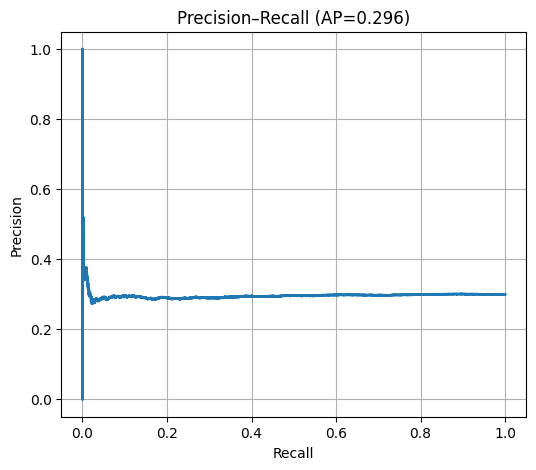

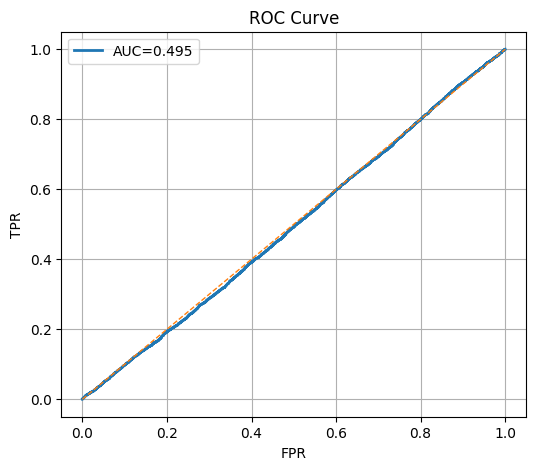

In [16]:
# === Celda 10 (Opcional): Curvas PR y ROC del mejor NB ===
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, auc

best_pipe.fit(X_train, y_train)
p_test = predict_proba_safe(best_pipe, X_test)

prec, rec, thr = precision_recall_curve(y_test, p_test)
fpr, tpr, _ = roc_curve(y_test, p_test)

ap = average_precision_score(y_test, p_test)
roc_auc = roc_auc_score(y_test, p_test)

plt.figure(figsize=(6,5))
plt.plot(rec, prec, lw=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision–Recall (AP={ap:.3f})")
plt.grid(True)
plt.show()

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, lw=2, label=f"AUC={roc_auc:.3f}")
plt.plot([0,1], [0,1], lw=1, linestyle="--")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()
